# Handwriting Recognition

- Grace Melissa     / 201900638
- Jennifer Atalya   / 202000208
- Renata Valencia   / 202001021
- Timothy Alexander / 202001183

## Import Library yang Dibutuhkan

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

## Mengumpulkan Data

In [ ]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip

!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [ ]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


## Memilah Dataset
Memilih baris-baris data yang diperlukan

In [ ]:
base_path = "data"

# inisialisasi list kosong untuk menampung kumpulan kata-kata dalam dataset
words_list = list()

words = open(f"{base_path}/words.txt", "r").readlines()
# melakukan iterasi pada setiap baris dataset
for line in words:
    # jika baris dimulai dengan '#' --> diabaikan
    if line[0] == "#":
        continue
    # jika tidak ada data yang "err" --> dimasukkan ke dalam list 'words_list'
    if line.split(" ")[1] != "err": 
        words_list.append(line)

len(words_list)
np.random.shuffle(words_list)

note:

contoh line 

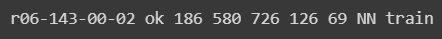

Dataset akan dibagi dengan perbandingan 90:5:5 (train:validation:test)

In [ ]:
# menghitung index untuk membagi data train 
split_index = int(0.9 * len(words_list))
# memisahkan data berdasarkan index sebelumnya
train_data = words_list[:split_index]
test_data = words_list[split_index:]

# menghitung index untuk membagi data test menjadi data test dan data validasi
val_split_index = int(0.5 * len(test_data))
# memisahkan data berdasarkan index sebelumnya
validation_data = test_data[:val_split_index]
test_data = test_data[val_split_index:]

assert len(words_list) == len(train_data) + len(validation_data) + len(test_data)

print(f"Total training samples: {len(train_data)}")
print(f"Total validation samples: {len(validation_data)}")
print(f"Total test samples: {len(test_data)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


## Data input pipeline

1. Mempersiapkan path  dari gambar yang akan digunakan

In [ ]:
base_image_path = os.path.join(base_path, "words")

def get_image_paths_and_labels(data):
    # menginisialisasi list untuk paths dan corrected data 
    paths = []
    corrected_data = []
    for (i, file_line) in enumerate(data):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # setiap baris akan mamiliki format berikut:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        part1 = image_name.split("-")[0]
        part2 = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, part1, part1 + "-" + part2, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_data.append(file_line.split("\n")[0])

    return paths, corrected_data

train_img_paths, train_labels = get_image_paths_and_labels(train_data)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_data)
test_img_paths, test_labels = get_image_paths_and_labels(test_data)

2. Mempersiapkan label yang sebenarnya 

In [ ]:
# inisialisasi list untuk label
train_labels_cleaned = []

# inisialisasi set characters untuk menampung karakter
# menggunakan set agar tidak ada data yang double
characters = set()

# inisialisasi variabel untuk menampung panjang maksimum kosa kata
max_len = 0

# iterasi untuk setiap label dalam train label
for label in train_labels:
    # memisahkan label berdasarkan spasi
    label = label.split(" ")[-1].strip()
    # memasukan karakter dalam label ke dalam set characters
    for char in label:
        characters.add(char)

    # memperbarui nilai max_len
    max_len = max(max_len, len(label))
    # manambahkan label ke dalam list
    train_labels_cleaned.append(label)

# karakter dalam set diurutkan
characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

3. Melakukan hal yang sama pada label validasi dan test

In [ ]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

## Membangun karakter dari kosa kata 

contoh: "aku" dan "kamu", character vocabulary-nya akan menjadi {a, k, m, u}

In [ ]:
# Untuk menyesuaikan data
AUTOTUNE = tf.data.AUTOTUNE

# Memetakan characters menjadi integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Memetakan integers kembali menjadi original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

## Menyesuaikan Ukuran Tanpa Distorsi

Menyeragamkan ukuran gambar diperlukan untuk membagi dataset training menjadi kelompok-kelompok yang lebih kecil

In [ ]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)
    # cek berapa banyak padding yang diperlukan
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Hanya dibutuhkan jika menginginkan jumlah padding yang sama di kedua sisi
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

## Menggabungkan semua utilities untuk mempersiapkan dataset

- preprocessing gambar
- vectorize label
- process image labels
- prepare dataset

In [ ]:
# inisialisasi ukuran batch, padding, panjang dan lebar gambar
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

# fungsi untuk prapemrosesan gambar
def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

# fungsi mengubah label ke dalam bentuk vektor
def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

# fungsi untuk memroses label gambar
def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

# fungsi untuk mempersiapkan dataset
def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

## Mempersiapkan objek tf.data.Dataset 

In [ ]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

## Memvisualisasi beberapa sampel dataset

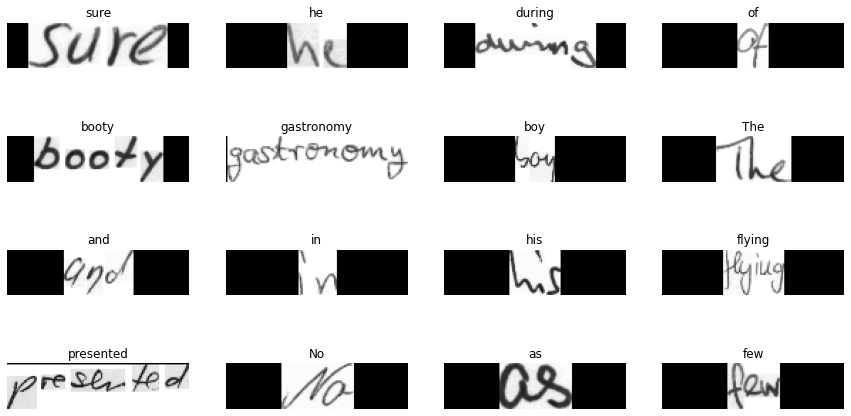

In [ ]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

## Model

Model kami akan menggunakan CTC loss sebagai titik akhir layer

In [ ]:
# Membuat kelas CTCLayer
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # Mengembalikan perhitungan predisksi
        return y_pred


def build_model():
    # Memasukan input ke model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # Konvolusi pertama
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Konvolusi kedua
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Harus menggunakan 2 max poop dengan pool size dan stride 2.
    # Maka dari itu, peta fitur yang di-downsampling berukuran 4x lebih kecil.
    # Jumlah filter di layer terakhir adalah 64. 
    # Lakukan reshape sebelum meneruskan output ke bagian model RNN
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNN
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 adalah untuk memperhitungkan dua token khusus yang diperkenalkan oleh CTC loss.
    # Rekomendasi dari: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Tampahkan layer CTC untuk menghitung CTC loss pada setiap langkah
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define modelnya
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer
    opt = keras.optimizers.Adam()

    # Compile model, lalu return
    model.compile(optimizer=opt)
    return model


# bangun model
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

## Metrik Evaluasi

1. Memisahkan gambar dan label validasi

In [ ]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

2. Membuat fungsi untuk memantau edit distance

In [ ]:
# Membuat fungsi menghitung jarak
def calculate_edit_distance(labels, predictions):
    # Mengambil 1 batch dan ubah label ke sparse tensor
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Membuat prediksi dan ubah ke sparse tensor
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Hitung masing-masing edit distance dan dibuat rata-rata
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


##Training

In [ ]:
epochs = 100
model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train model
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/100
1357/1357 [==============================] - 145s 94ms/step - loss: 13.7061 - val_loss: 12.1866
Epoch 2/100
1357/1357 [==============================] - 80s 59ms/step - loss: 10.6618 - val_loss: 9.6864
Epoch 3/100
1357/1357 [==============================] - 80s 59ms/step - loss: 9.1053 - val_loss: 8.2120
Epoch 4/100
1357/1357 [==============================] - 82s 61ms/step - loss: 7.5802 - val_loss: 6.3317
Epoch 5/100
1357/1357 [==============================] - 78s 58ms/step - loss: 6.0636 - val_loss: 4.8408
Epoch 6/100
1357/1357 [==============================] - 75s 56ms/step - loss: 5.0850 - val_loss: 4.0282
Epoch 7/100
1357/1357 [==============================] - 81s 59ms/step - loss: 4.4375 - val_loss: 3.5276
Epoch 8/100
1357/1357 [==============================] - 76s 56ms/step - loss: 3.9954 - val_loss: 3.2388
Epoch 9/100
1357/1357 [==============================] - 76s 56ms/step - loss: 3.6595 - val_loss: 2.9315
Epoch 10/100
1357/1357 [===========================

## Hasil Prediksi

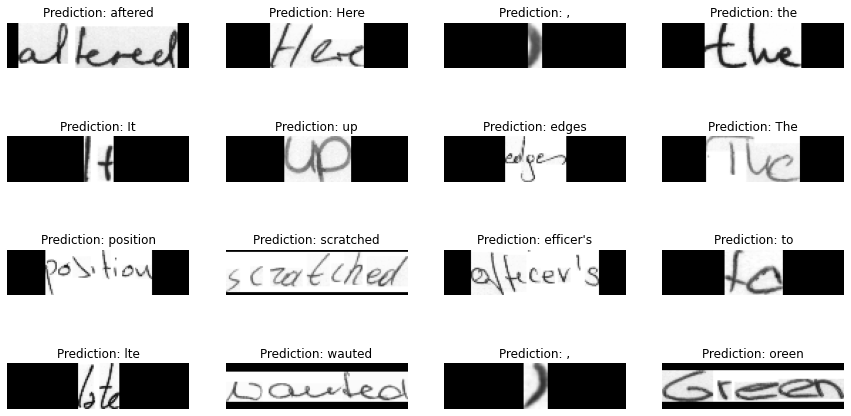

In [ ]:
# Fungsi untuk memprediksi
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    
    output_text = []

    # Iterasi pada hasil dan kembali ke text
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Cek hasil dengan beberapa sampel
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()